Notebook objective: Train & test fixed effects linear model with target encoding. Goal is to compare performance, SHAP values & fixed effects with LMM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features, groupings and target
X = df.drop(["life_expectancy"], axis = 1)
y = df.life_expectancy

In [6]:
# Create preprocessing pipeline
encoder = TargetEncoder(cols = "country")
scaler = MinMaxScaler()
pipeline = Pipeline([
    ("encoder", encoder), 
    ("scaler", scaler)
])

In [7]:
pipeline

Pipeline(steps=[('encoder', TargetEncoder(cols='country')),
                ('scaler', MinMaxScaler())])

In [8]:
# Create cv splitter
cv = GroupKFold(n_splits = 4)

## Testing & diagnostics

In [9]:
# Initialize lists to store validation results
val_list = []
preds_list = []
resids_list = []
scores_mse = []
scores_rmse = []
scores_mape = []

In [10]:
# Perform crossvalidation
for i, (train_index, val_index) in enumerate(cv.split(X = X, groups = X.country)):

    # Split train - val
    X_train, y_train = X.iloc[train_index, ], y[train_index]
    X_val, y_val = X.iloc[val_index, ], y[val_index]

    # Preprocess features
    X_train = pipeline.fit_transform(X_train, y_train)
    X_val = pipeline.transform(X_val)

    # Train fixed effects model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Save actual values
    val_list.append(y_val)

    # Make predictions on test data
    preds = model.predict(X_val)
    preds_list.append(preds)

    # Calculate prediction residuals
    resids = y_val - preds
    resids_list.append(resids)

    # Calculate scores
    mse = mean_squared_error(y_val, preds)
    scores_mse.append(mse)

    rmse = mean_squared_error(y_val, preds, squared = False)
    scores_rmse.append(rmse)

    mape = mean_absolute_percentage_error(y_val, preds)
    scores_mape.append(mape)


In [11]:
# Print average MSE, RMSE, MAPE
print("MSE:")
print(round(np.mean(scores_mse), 4))

print("RMSE:")
print(round(np.mean(scores_rmse), 4))

print("MAPE:")
print(round(np.mean(scores_mape), 4))

MSE:
55.426
RMSE:
7.4383
MAPE:
0.0926


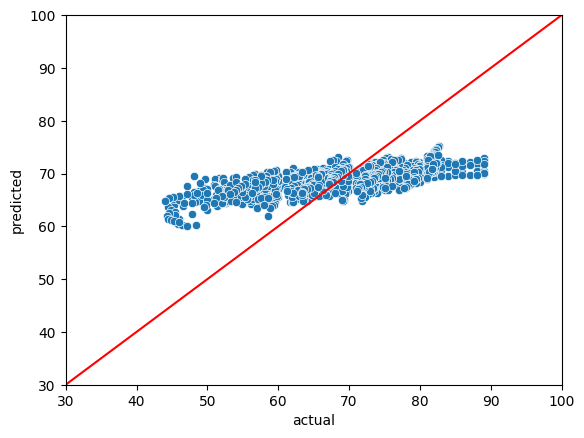

In [12]:
# Plot predicted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(val_list).ravel(),  
    y = np.concatenate(preds_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

Predictions seem "stuck" roughly between 60-75. Since all predictions are for out-of-sample countries, this suggests the features alone don't explain extremes in life expectancy.

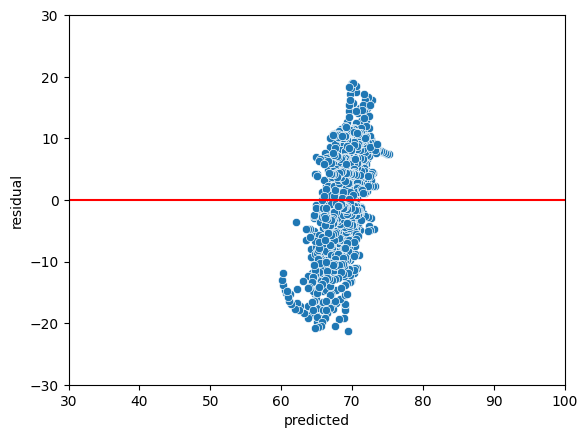

In [13]:
# Predicted vs residual
_ = sns.scatterplot(
    x = np.concatenate(preds_list).ravel(), 
    y = np.concatenate(resids_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

Predictions & residuals don't seem too biased for particular out-of-sample countries, just erroneous across the board for extreme cases.

## Inference

In [14]:
# Train final model
model = LinearRegression()
X_scaled = pd.DataFrame(pipeline.fit_transform(X, y), columns = X.columns)
model.fit(X_scaled, y)

LinearRegression()

In [15]:
# Get fitted values & residuals
fitted = model.predict(X_scaled)
fitted_resids = y - fitted

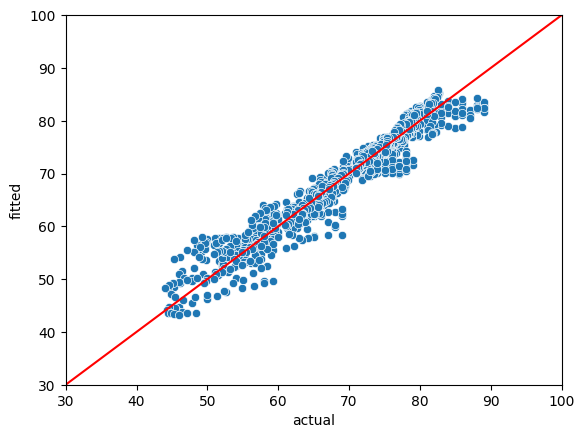

In [16]:
# Plot fitted vs. actual
_ = sns.scatterplot(
    x = y,  
    y = fitted
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

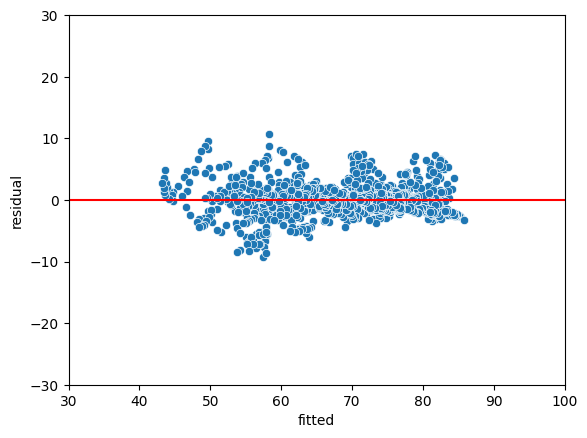

In [17]:
# Plot fitted vs. residual
_ = sns.scatterplot(
    x = fitted, 
    y = fitted_resids
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-30, 30)
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

In [18]:
# Print model parameters
coefs = model.coef_
intercept = model.intercept_

In [19]:
print(pd.Series(coefs, X.columns))
print("intercept:                   " + str(intercept))

country                           30.891601
year                               2.748185
alcohol                           -2.282047
percentage_expenditure            -1.472775
hepatitis_b                       -0.100568
measles                            0.080621
bmi                                0.752130
polio                              0.425041
total_expenditure                  0.677216
diphtheria                         1.230094
hiv_aids                          -5.404273
gdp                                2.369264
population                         0.027967
thinness_1_19                     -1.079707
thinness_5_9                       1.126978
income_composition_of_resources    2.134259
schooling                          6.018719
developing                         0.114586
dtype: float64
intercept:                   43.114714007724466


The predictors are scaled 0 to 1. The intercept is 43 and the coefficient for country is roughly 30.
This suggests the model relies heavily on the intercept & country variable to come up with predictions close to the target average: 
Countries target encoded closer to 0 have an estimate closer to 43, and those encoded closer to 1 have an estimate closer to 73. Other predictors make relatively small contributions.

In [20]:
df.life_expectancy.mean()

69.3023044269254

In [21]:
# Get SHAP values
explainer = shap.LinearExplainer(model, X_scaled)
shap_values = explainer(X_scaled)

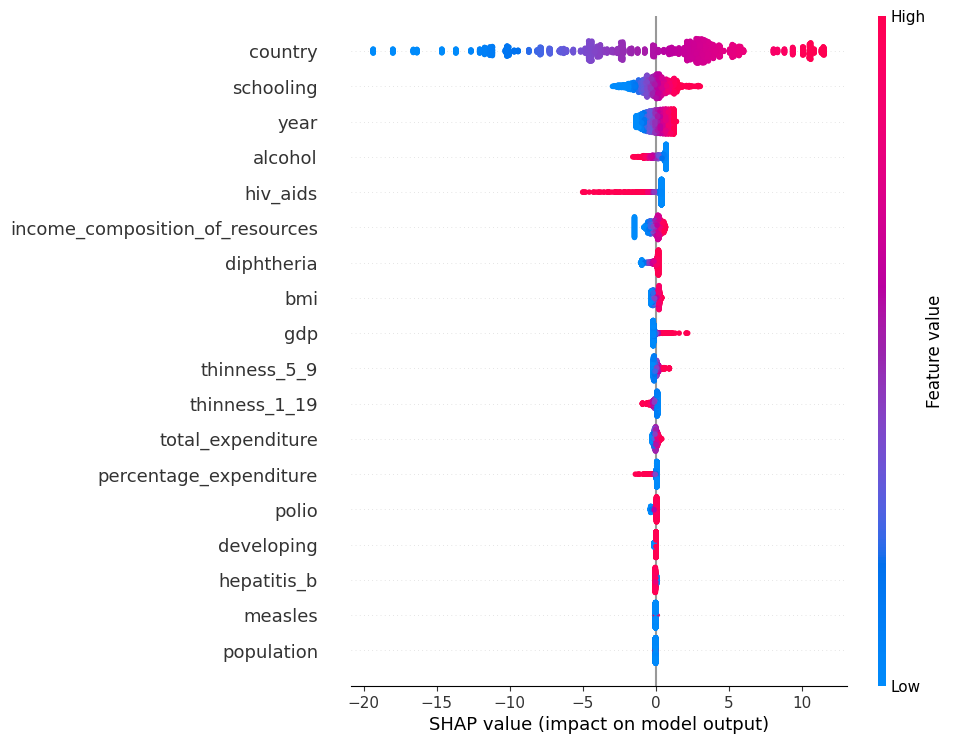

In [22]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

The dominant predictor is the target encoded country variable. Other predictors have effects that are small in comparison, but some are quite discriminatory, such as HIV, especially for extreme observations.

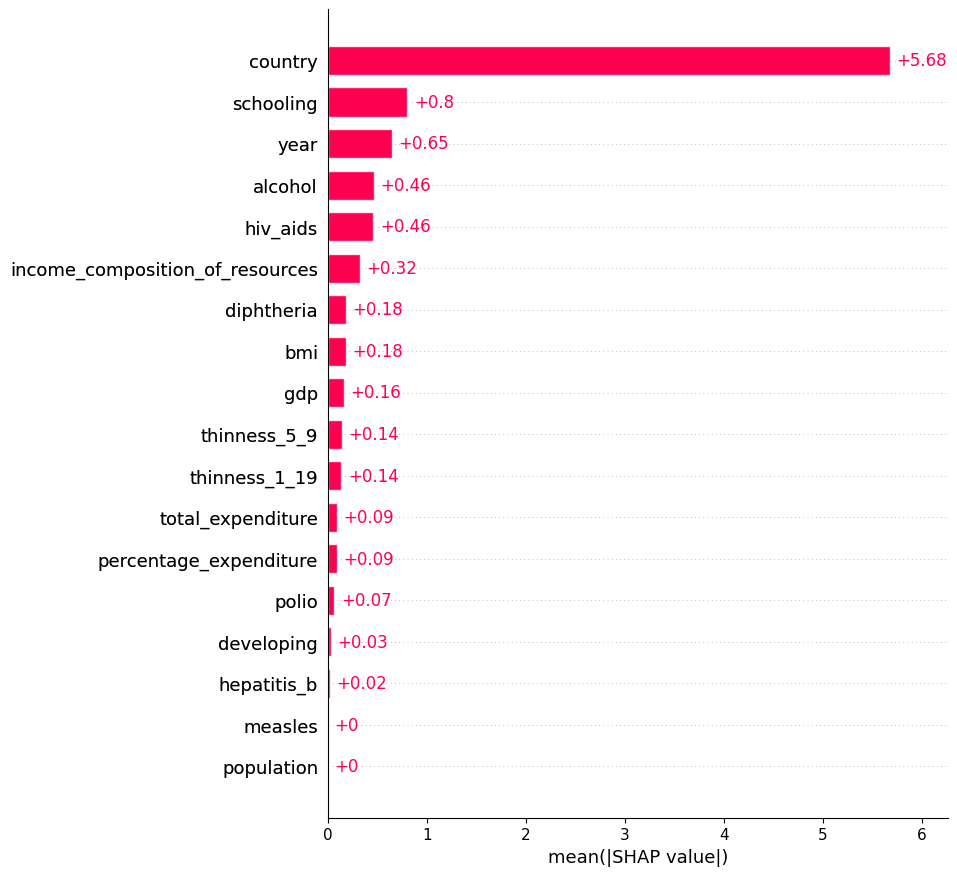

In [23]:
shap.plots.bar(shap_values, max_display = 20)